<a href="https://colab.research.google.com/github/reetika-goel/Emerging-Technologies/blob/master/Dogs_vs_Cat_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Load Libraries**

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

import os
#!ls
#os.getcwd()                    #To check if image was uploaded or not

print(os.listdir("/content/drive/My Drive/Colab Notebooks/Dogs_vs_Cat_dataset"))

Using TensorFlow backend.


['train', 'test1']


In [0]:
filenames = os.listdir("/content/drive/My Drive/Colab Notebooks/Dogs_vs_Cat_dataset/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append('dog')
    else:
        categories.append('cat')

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,cat.4952.jpg,cat
1,cat.3783.jpg,cat
2,dog.10199.jpg,dog
3,dog.7919.jpg,dog
4,dog.9934.jpg,dog


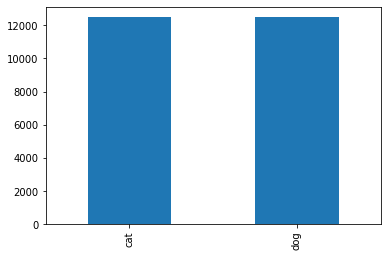

In [0]:
df['category'].value_counts().plot.bar()

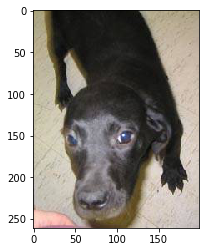

In [0]:
sample = random.choice(filenames)
image = load_img("/content/drive/My Drive/Colab Notebooks/Dogs_vs_Cat_dataset/train/"+sample)
plt.imshow(image)

**Build Model**

In [0]:
image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 5
batch_size = 16

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True

last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()





58892288/58889256 [==============================] - 3s 0us/step







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 

#**Prepare Test and Train Data**

In [0]:
train_df, validate_df = train_test_split(df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

# validate_df = validate_df.sample(n=100).reset_index() # use for fast testing code purpose
# train_df = train_df.sample(n=1800).reset_index() # use for fast testing code purpose

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

#**Training Generator**

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/drive/My Drive/Colab Notebooks/Dogs_vs_Cat_dataset/train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 22509 validated image filenames belonging to 2 classes.


#**Validation Generator**

In [0]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/My Drive/Colab Notebooks/Dogs_vs_Cat_dataset/train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 2501 validated image filenames belonging to 2 classes.


##**See Sample Generated Images**

Found 1 validated image filenames belonging to 1 classes.


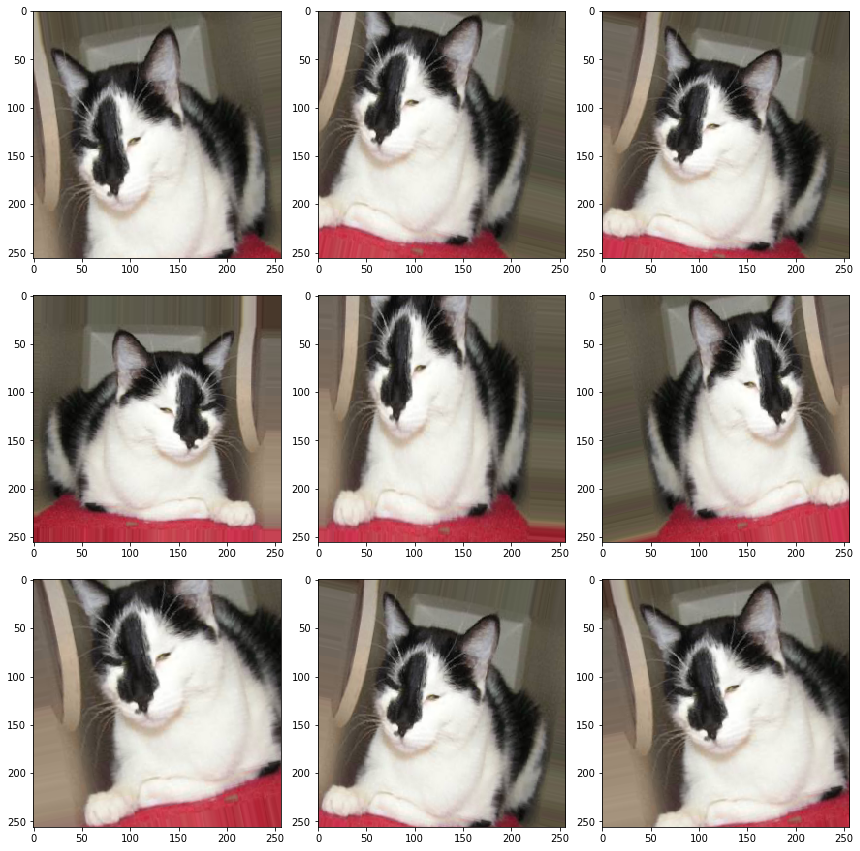

In [0]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/drive/My Drive/Colab Notebooks/Dogs_vs_Cat_dataset/train/", 
    x_col='filename',
    y_col='category',
#    class_mode='binary'
)
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

#**Fit Model**

In [0]:
# fine-tune the model
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)



Epoch 1/5
1406/1406 [==============================] - 9278s 7s/step - loss: 0.3087 - acc: 0.8547 - val_loss: 0.1390 - val_acc: 0.9439
Epoch 2/5
1406/1406 [==============================] - 461s 328ms/step - loss: 0.1510 - acc: 0.9388 - val_loss: 0.1164 - val_acc: 0.9553
Epoch 3/5
1406/1406 [==============================] - 462s 329ms/step - loss: 0.1232 - acc: 0.9501 - val_loss: 0.1088 - val_acc: 0.9557
Epoch 4/5
1406/1406 [==============================] - 461s 328ms/step - loss: 0.1069 - acc: 0.9564 - val_loss: 0.0949 - val_acc: 0.9602
Epoch 5/5
1406/1406 [==============================] - 464s 330ms/step - loss: 0.0976 - acc: 0.9602 - val_loss: 0.0925 - val_acc: 0.9622


In [0]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.961138  ;  loss = 0.094538 


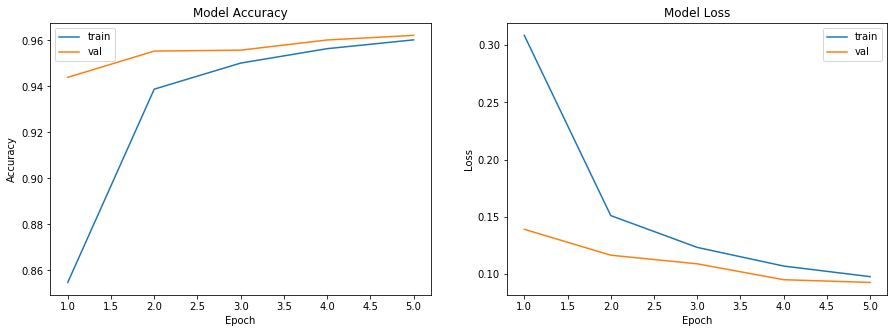

In [0]:
def plot_model_history(model_history, acc='acc', val_acc='val_acc'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [0]:
Y_val = validate_df['category']
y_pred =  model.predict_generator(validation_generator)

In [0]:
threshold = 0.5
y_final = np.where(y_pred > threshold, 'dog', 'cat')

In [0]:
y_final.size

2501

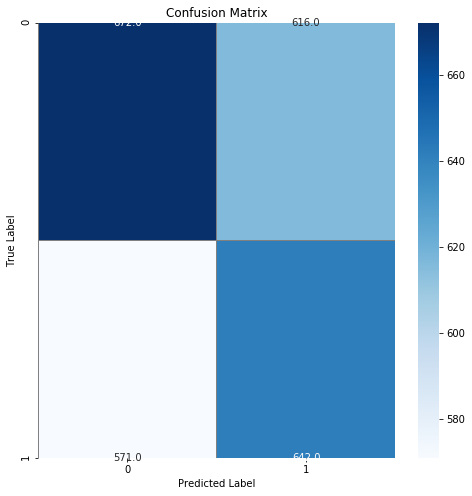

In [0]:
# Predict the values from the validation dataset

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val, y_final) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [0]:
# Generate a classification report
report = classification_report(Y_val, y_final, target_names=['cat','dog'])

print(report)

              precision    recall  f1-score   support

         cat       0.54      0.52      0.53      1288
         dog       0.51      0.53      0.52      1213

    accuracy                           0.53      2501
   macro avg       0.53      0.53      0.53      2501
weighted avg       0.53      0.53      0.53      2501



#**Prepare Testing Data**

In [0]:
test_filenames = os.listdir("/content/drive/My Drive/Colab Notebooks/Dogs_vs_Cat_dataset/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

#**Create Testing Generator**

In [0]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/drive/My Drive/Colab Notebooks/Dogs_vs_Cat_dataset/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 12500 validated image filenames.


#**Predict**

In [0]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 'dog', 'cat')

#**See Predicted Results**

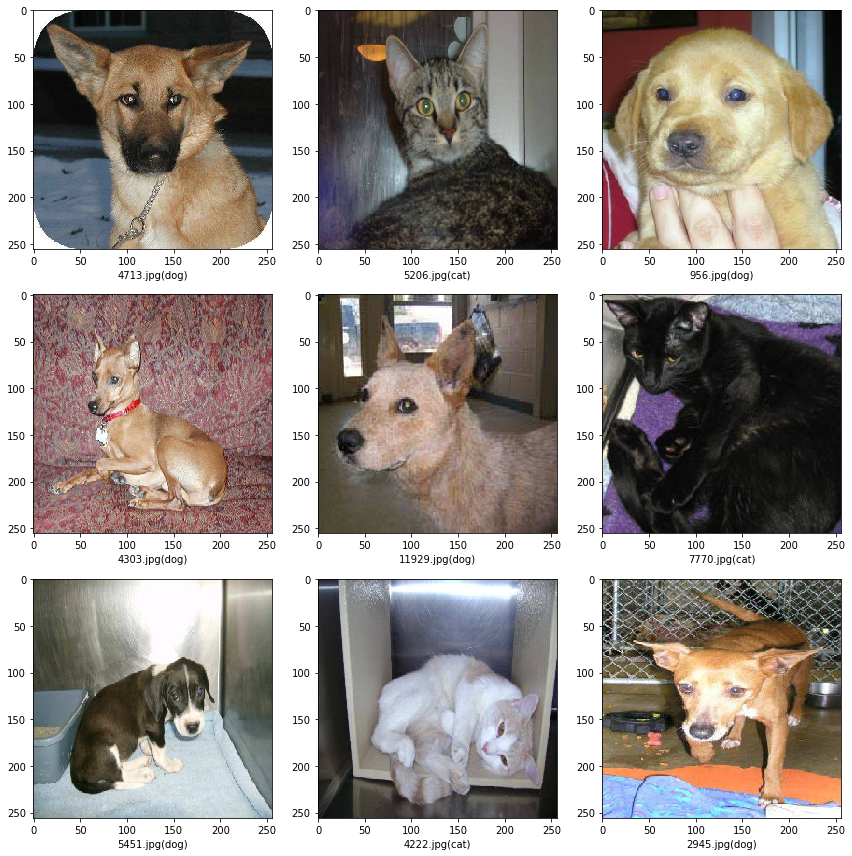

In [0]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/drive/My Drive/Colab Notebooks/Dogs_vs_Cat_dataset/test1/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()

#**Submission**

Text(0.5, 1.0, '(Test data)')

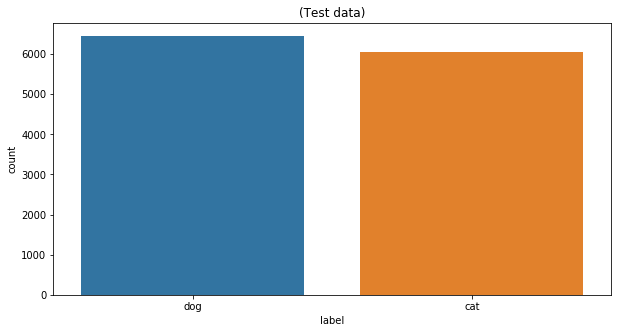

In [0]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission_13010030.csv', index=False)

plt.figure(figsize=(10,5))
sns.countplot(submission_df['label'])
plt.title("(Test data)")